<a href="https://colab.research.google.com/github/wei1347/Coursera_Capstone/blob/main/week5_code_The_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Import Libraries

In [49]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import folium
import numpy as np
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

# import k-means from clustering stage
from sklearn.cluster import KMeans

# 3. Scrape Neighborhoods Data

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [5]:
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [6]:
# save this dataframe in a CSV file
df.to_csv('Neighborhood Data.csv')

# 4. Data Analysis

* In this step we'll do thses following steps
Only process the cells that have an assigned borough. 

* Ignore cells with a borough that is Not assigned.

* More than one neighborhood can exist in one postal code area. 

* For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. 

* These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.

In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [7]:
# drop rows having null value and value assigned as "Not assigned"
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [8]:
# check for missing value
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [9]:
# Check if we still have any Neighborhoods that are Not Assigned
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [10]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [11]:
# shape of dataframe
df.shape

(103, 3)

Now data is cleaned and all the requirements are met. So we just have to add the Latitude and Longitudes of each location.
Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood. Now we are going to create a new table with the Latitudes and Longitudes corresponding to the different PostalCodes

In [20]:
geo_df = pd.read_csv("Geospatial_Coordinates.csv")
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [22]:
# Merging the Data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough  ...   Latitude  Longitude
0        M3A        North York  ...  43.753259 -79.329656
1        M4A        North York  ...  43.725882 -79.315572
2        M5A  Downtown Toronto  ...  43.654260 -79.360636
3        M6A        North York  ...  43.718518 -79.464763
4        M7A      Queen's Park  ...  43.662301 -79.389494

[5 rows x 5 columns]

In [23]:
# lets find out how many neighborhoods in each borough
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

In [24]:
df_toronto = df
df_toronto.head()

PostalCode           Borough  ...   Latitude  Longitude
0        M3A        North York  ...  43.753259 -79.329656
1        M4A        North York  ...  43.725882 -79.315572
2        M5A  Downtown Toronto  ...  43.654260 -79.360636
3        M6A        North York  ...  43.718518 -79.464763
4        M7A      Queen's Park  ...  43.662301 -79.389494

[5 rows x 5 columns]

In [25]:
# Create a list and store all unique borough names
boroughs = df_toronto['Borough'].unique().tolist()

In [26]:
# Obtain the Latitude and Longitude of Toronto by taking mean of Latitude/Longitude of all postal code
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [27]:
# This will color categorize each borough
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [28]:
map_toronto = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=10.5)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.8).add_to(map_toronto)  
    
map_toronto

Next we will define foursquare Credentials

In [29]:
CLIENT_ID = 'OBDWYHZQJBTMXPX03BR4G34ICSNWSSI2DMVBH4MNNP4OOV1R' # your Foursquare ID
CLIENT_SECRET = 'MC2OA5IPUBVKSMM0H3XATYJNZNFGRULEBCKAQIS52RCATMOQ' # your Foursquare Secret
VERSION = 20210725 # Foursquare API version

print('Credentials Stored')

Credentials Stored


4.3. Now, let's get the top 100 venues that are in Lawrence Park within a radius of 500 meters.

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 500 # define radius
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [32]:
toronto_venues.tail()

Neighborhood  ...          Venue Category
2114  Mimico NW, The Queensway West, South of Bloor,...  ...           Tanning Salon
2115  Mimico NW, The Queensway West, South of Bloor,...  ...              Kids Store
2116  Mimico NW, The Queensway West, South of Bloor,...  ...  Thrift / Vintage Store
2117  Mimico NW, The Queensway West, South of Bloor,...  ...                     Gym
2118  Mimico NW, The Queensway West, South of Bloor,...  ...           Burrito Place

[5 rows x 7 columns]

In [33]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  ...  Venue Category
Neighborhood                                                            ...                
Agincourt                                                            5  ...               5
Alderwood, Long Branch                                               8  ...               8
Bathurst Manor, Wilson Heights, Downsview North                     22  ...              22
Bayview Village                                                      4  ...               4
Bedford Park, Lawrence Manor East                                   24  ...              24
...                                                                ...  ...             ...
Willowdale West                                                      5  ...               5
Woburn                                                               4  ...               4
Woodbine Heights                                                     6  ...               6
York Mills West                                                      2  ...               2
York Mills, Silver Hills                                             1  ...               1

[99 rows x 6 columns]

4.4. How many unique venues are there in all neighborhood ?


In [34]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 268 uniques vanue categories.


In [35]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique())

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Bus Stop' 'Food & Drink Shop'
 'Hockey Arena' 'Coffee Shop' 'Portuguese Restaurant' 'French Restaurant'
 'Bakery' 'Distribution Center' 'Restaurant' 'Spa' 'Pub' 'Breakfast Spot'
 'Gym / Fitness Center' 'Historic Site' 'Chocolate Shop' 'Farmers Market'
 'Performing Arts Venue' 'Dessert Shop' 'Mexican Restaurant' 'Yoga Studio'
 'Shoe Store' 'Theater' 'Café' 'Event Space' 'Asian Restaurant'
 'Electronics Store' 'Art Gallery' 'Bank' 'Beer Store' 'Hotel'
 'Health Food Store' 'Sushi Restaurant' 'Antique Shop' 'Boutique'
 'Furniture / Home Store' 'Vietnamese Restaurant' 'Clothing Store'
 'Accessories Store' 'Arts & Crafts Store' 'Italian Restaurant' 'Beer Bar'
 'Creperie' 'Burrito Place' 'Hobby Shop' 'Diner' 'Fried Chicken Joint'
 'Japanese Restaurant' 'Smoothie Shop' 'Sandwich Place' 'Gym'
 'College Auditorium' 'Bar' 'Print Shop' 'Caribbean Restaurant'
 'Gastropub' 'Pharmacy' 'Pizza Place' 'Pet Store' 'Intersection'
 'Flea Market' 'Ath

In [36]:
"Chinese Restaurant" in toronto_venues['Venue Category'].unique()

True

# 5. Data Analysis

5.1. Now we will analyze each neighborhood
As the column "Venue Category" contain categorical value.So we need to convert it to numerical values by one hot encoding.

In [37]:
# one hot encoding
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2119, 269)


Neighborhoods  Accessories Store  ...  Women's Store  Yoga Studio
0         Parkwoods                  0  ...              0            0
1         Parkwoods                  0  ...              0            0
2         Parkwoods                  0  ...              0            0
3         Parkwoods                  0  ...              0            0
4  Victoria Village                  0  ...              0            0

[5 rows x 269 columns]

In [38]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(99, 269)


Neighborhoods  ...  Yoga Studio
0                                        Agincourt  ...          0.0
1                           Alderwood, Long Branch  ...          0.0
2  Bathurst Manor, Wilson Heights, Downsview North  ...          0.0
3                                  Bayview Village  ...          0.0
4                Bedford Park, Lawrence Manor East  ...          0.0

[5 rows x 269 columns]

In [43]:
chi = to_grouped[["Neighborhoods","Chinese Restaurant"]]
chi.head()

Neighborhoods  Chinese Restaurant
0                                        Agincourt                0.00
1                           Alderwood, Long Branch                0.00
2  Bathurst Manor, Wilson Heights, Downsview North                0.00
3                                  Bayview Village                0.25
4                Bedford Park, Lawrence Manor East                0.00

In [45]:
# rename column "Neighborhoods" to "Neighborhood"
chi = chi.rename(columns={'Neighborhoods':'Neighborhood'})

# 6. Clustering
We will use k-means clustering. But first we will find the best K value using the Elbow Point method.

In [47]:
# drop "Neighborhood" column from the dataframe
X = chi.drop(['Neighborhood'], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1008: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sampl

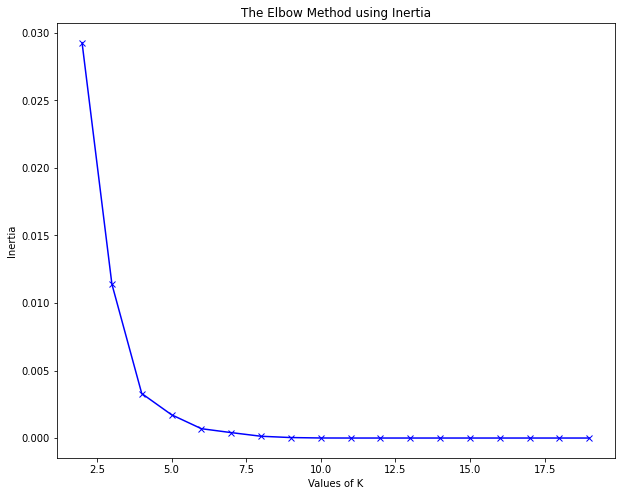

In [52]:
# find 'k' value by Elbow Method
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

Here,We saw that the optimum K value is 3 so we will have a resulting of 3 clusters.

In [53]:
kclusters = 3

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [54]:
# unique value in target column
np.unique(kmeans.labels_)

array([0, 1, 2], dtype=int32)

In [55]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
to_merged = ita.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [56]:
to_merged.head()

Neighborhood  ...  Cluster Labels
0                                        Agincourt  ...               0
1                           Alderwood, Long Branch  ...               0
2  Bathurst Manor, Wilson Heights, Downsview North  ...               0
3                                  Bayview Village  ...               1
4                Bedford Park, Lawrence Manor East  ...               0

[5 rows x 3 columns]

In [57]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2119, 9)


Neighborhood  Chinese Restaurant  ...  Venue Longitude             Venue Category
0    Agincourt                 0.0  ...       -79.260203             Breakfast Spot
0    Agincourt                 0.0  ...       -79.259208  Latin American Restaurant
0    Agincourt                 0.0  ...       -79.258584                     Lounge
0    Agincourt                 0.0  ...       -79.259714             Clothing Store
0    Agincourt                 0.0  ...       -79.267989               Skating Rink

[5 rows x 9 columns]

In [58]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2119, 9)


Neighborhood  ...       Venue Category
59  North Toronto West  ...        Metro Station
59  North Toronto West  ...       Ice Cream Shop
59  North Toronto West  ...            Pet Store
59  North Toronto West  ...  Rental Car Location
22     Don Mills South  ...   Dim Sum Restaurant

[5 rows x 9 columns]

In [59]:
to_merged['Venue Category'].value_counts()['Chinese Restaurant']

14

We see that there are a total of 46 locations with Italian Restaurants in Toronto
We will create a new dataframe with the Neighborhood and Italian Restaurants

6.2. Visualize Clustering on Google Map

In [60]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

6.2.  How many Neighborhoods per Cluster?

In [67]:
chi["Cluster Labels"] = kmeans.labels_
chi.head()

Neighborhood  ...  Cluster Labels
0                                        Agincourt  ...               0
1                           Alderwood, Long Branch  ...               0
2  Bathurst Manor, Wilson Heights, Downsview North  ...               0
3                                  Bayview Village  ...               1
4                Bedford Park, Lawrence Manor East  ...               0

[5 rows x 3 columns]

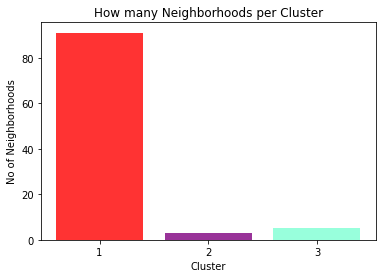

In [68]:
objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = chi['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [69]:
# How many neighborhoods in each cluster
ita['Cluster Labels'].value_counts()

0    91
2     5
1     3
Name: Cluster Labels, dtype: int64

Analysis of each Cluster

In [70]:
# This will create a dataframe with borough of each neighborhood which we will merge with each cluster dataframe
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [71]:
# Red 

cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  ...  Venue Longitude        Venue Category
0  North York         Parkwoods  ...       -79.333021  Fast Food Restaurant
1  North York         Parkwoods  ...       -79.332140                  Park
2  North York         Parkwoods  ...       -79.333114     Food & Drink Shop
3  North York         Parkwoods  ...       -79.326351              Bus Stop
4  North York  Victoria Village  ...       -79.317418     French Restaurant

[5 rows x 10 columns]

In [72]:
# Purple 
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')

In [73]:
# Blue
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')

Text(0.5, 1.0, 'Average number of Chinese Restaurants per Cluster')

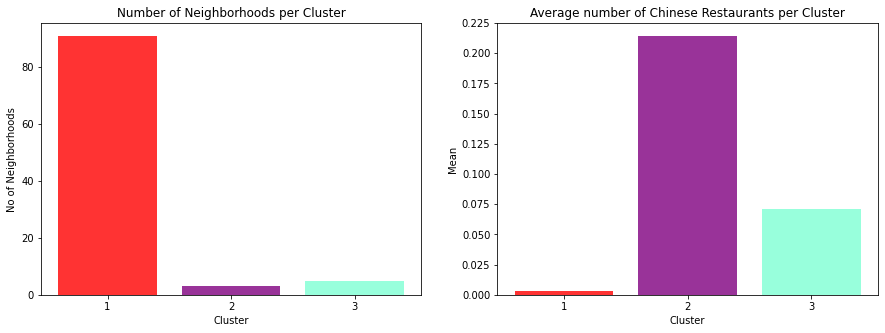

In [77]:
plt.figure(figsize=(15,5))

# Plot-1 ( Number of Neighborhoods per Cluster )

plt.subplot(1,2,1)
objects = (1,2,3)
y_pos = np.arange(len(objects))
performance = chi['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

# Plot-2 ( Average number of Italian Restaurants per Cluster )

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Chinese Restaurant'].mean(),df_cluster2['Chinese Restaurant'].mean(),df_cluster3['Chinese Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Chinese Restaurants per Cluster')